# TALLE DETECCION DE ANOMALIAS
#### Soluciona al dataset con descriptores ["Latencia_ms", "Throughput_mb_s"] el problema de arriba usando la normal univarida
### Juan Rave

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
# 1. seleccione los descriptores
columnas=['Latencia_ms','Throughput_mb_s']
train_data = pd.read_csv('data/tr_server_data.csv',header=None,names=columnas)
test_data = pd.read_csv('data/cv_server_data.csv',header=None,names=columnas) 

target_data = pd.read_csv('data/gt_server_data.csv',header=None,names=['Target'])

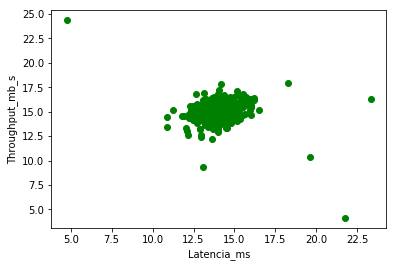

In [13]:
plt.figure()
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
plt.plot(train_data['Latencia_ms'], train_data['Throughput_mb_s'],'go')
plt.show()

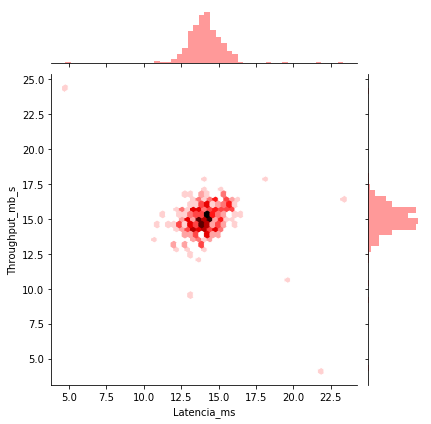

In [21]:
sns.jointplot(data = train_data, x = "Latencia_ms", y = "Throughput_mb_s", kind='hex', color='r') 

In [6]:
# 2. calculamos la media y la varianza para cada descriptor
def meanvariance(data, axis=0):
    mean_ = np.mean(data, axis=axis)
    variance_ = np.var(data, axis=axis)
    
    print(list(data.columns))
    print("mean: " + str(list(mean_)))
    print("variance: " + str(list(variance_)))

    return mean_, variance_

# obtenemos el mejor epsilon que agrupe nuestros datos
def get_threshold(probs, target):
    best_epsilon_ = 0
    best_f1_ = 0
    f_ = 0
    
    stepsize_ = (max(probs) - min(probs)) / 1000;
    epsilons_ = np.arange(min(probs),max(probs), stepsize_)
    
    for epsilon_ in np.nditer(epsilons_):
        predicciones_ = (probs < epsilon_) 
        
        f_ = f1_score(target, predicciones_, average='binary')
        if f_ > best_f1_:
            best_f1_ = f_
            best_epsilon_ = epsilon_
    
    return best_f1_, best_epsilon_

In [7]:
# 3. Dado un nuevo ejemplo calculamos la densidad

# definimos la funcion de densidad con base a la productoria
# funcion de densidad de probabilidad
def univariate_normal(x, mean, variance):
    return np.prod( (1. / np.sqrt(2 * np.pi * variance)) * np.exp(-(x - mean)**2 / (2 * variance)), axis=1 )

In [40]:
# obtenemos la media y la varianza del conjunto de datos de entrenamiento
mean_, variance_ = meanvariance(train_data)

# calculamos la funcion de densidad para cada par de datos tanto en el conjunto de entrenamiento, como pruebas
# usando la media y la varianza del conjunto de entrenamiento
p = univariate_normal(train_data, mean_, variance_)
pd = univariate_normal(test_data, mean_, variance_)

# obtenemos el umbral para el conjunto de pruebas
fscore, ep = get_threshold(pd, target_data.values)

print("fscore: " + str(fscore))
print("best epsilon: " + str(ep))

['Latencia_ms', 'Throughput_mb_s']
mean: [14.112252768729643, 14.99767459283387]
variance: [1.832677699495591, 1.7097153379212509]


/Users/juan.rave/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fscore: 0.8750000000000001
best epsilon: 8.990836637319745e-05


In [41]:
# 4. Es anormal si p(x) < e
outliers = np.asarray(np.where(p < ep))
print("anomalies: " + str(list(outliers)))

anomalies: [array([300, 301, 303, 304, 305, 306])]


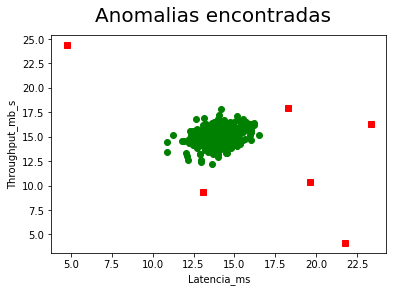

In [42]:
# graficamos la solucion enontrando las anomalias sobre el conjunto de entrenamiento
fig = plt.figure()
fig.suptitle('Anomalias encontradas', fontsize=20)
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
plt.plot(train_data['Latencia_ms'],train_data['Throughput_mb_s'],'go')
plt.plot(train_data.values[outliers,0],train_data.values[outliers,1],'rs')
plt.show()

anomalies: [array([300, 301, 302, 303, 304, 305, 306])]


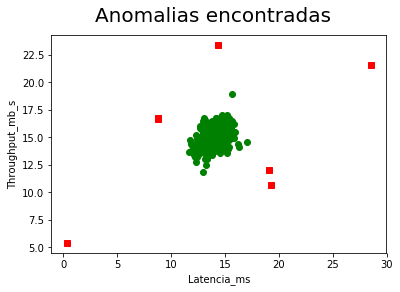

In [43]:
outliers = np.asarray(np.where(pd < ep))
print("anomalies: " + str(list(outliers)))

# graficamos la solucion enontrando las anomalias sobre el conjunto de pruebas
fig = plt.figure()
fig.suptitle('Anomalias encontradas', fontsize=20)
plt.xlabel('Latencia_ms')
plt.ylabel('Throughput_mb_s')
plt.plot(test_data['Latencia_ms'],test_data['Throughput_mb_s'],'go')
plt.plot(test_data.values[outliers,0],test_data.values[outliers,1],'rs')
plt.show()